In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
folder = '/Users/julianganzabal/.kaggle/competitions/jigsaw-toxic-comment-classification-challenge/'

In [4]:
train = pd.read_csv(folder+"train.csv")
test = pd.read_csv(folder+"test.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
submission = pd.read_csv(folder+"sample_submission.csv")

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

In [7]:
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

In [8]:
toxic_ratio = (Y_train.sum(axis = 1) > 0).sum()/Y_train.shape[0]
print(toxic_ratio)

0.101766553167


In [9]:
toxic_indexes_train = (Y_train.sum(axis = 1) > 0)
toxic_indexes_valid = (Y_valid.sum(axis = 1) > 0)
raw_text_train_toxic = raw_text_train[toxic_indexes_train]
raw_text_valid_toxic = raw_text_valid[toxic_indexes_valid]
Y_train_toxic = Y_train[toxic_indexes_train]
Y_valid_toxic = Y_valid[toxic_indexes_valid]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 200000

tfidf_vectorizer = TfidfVectorizer(max_df=0.99, min_df=1,
                                   max_features=max_features,
                                   #tokenizer=tokenize,
                                   stop_words='english')

%time tfidf_matrix_train_toxic = tfidf_vectorizer.fit_transform(raw_text_train_toxic)

CPU times: user 1.06 s, sys: 39.2 ms, total: 1.1 s
Wall time: 2.13 s


In [11]:
%time tfidf_matrix_valid_toxic = tfidf_vectorizer.transform(raw_text_valid_toxic)

CPU times: user 114 ms, sys: 4.57 ms, total: 119 ms
Wall time: 161 ms


In [12]:
tfidf_matrix_train_toxic.shape

(14615, 32945)

In [13]:
dense_matrix_train_toxic = tfidf_matrix_train_toxic.todense()
dense_matrix_valid_toxic = tfidf_matrix_valid_toxic.todense()

In [14]:
dense_matrix_train_toxic.shape, dense_matrix_valid_toxic.shape

((14615, 32945), (1610, 32945))

In [15]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import initializers

Using TensorFlow backend.


In [16]:
default_initializer = initializers.normal(mean=0, stddev=0.001)
# default_initializer = 'zeros'

In [17]:
input_features = dense_matrix_train_toxic.shape[1]
output_size = Y_train_toxic.shape[1]
hidden_units = 100
lambd = 0 #0.001
model_sig_nn = Sequential()
# model_sig_nn.add(Dense(200,
#                        input_dim=input_features, 
#                        kernel_regularizer=regularizers.l2(lambd), 
#                        kernel_initializer=default_initializer,
#                        name="Capa_Oculta_1"))
# model_sig_nn.add(Activation('sigmoid'))
model_sig_nn.add(BatchNormalization(input_shape=(input_features,)))
model_sig_nn.add(Dense(128,
                       #input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_2"))
model_sig_nn.add(BatchNormalization())
model_sig_nn.add(Activation('relu'))
model_sig_nn.add(Dropout(0.15))
model_sig_nn.add(Dense(output_size,
                       #input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.0001 
batch_size = 256
epochs = 10

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr, decay=0.001)

model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy']) #auc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32945)             131780    
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 128)               4217088   
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Capa_Salida (Dense)          (None, 6)                 774       
_________________________________________________________________
output (Activation)          (None, 6)                 0         
Total para

In [18]:
model_sig_nn.evaluate(dense_matrix_valid_toxic, Y_valid_toxic)

1610/1610 [==============================] - 4s 3ms/step


[0.69314719068337671, 0.50734990042929329]

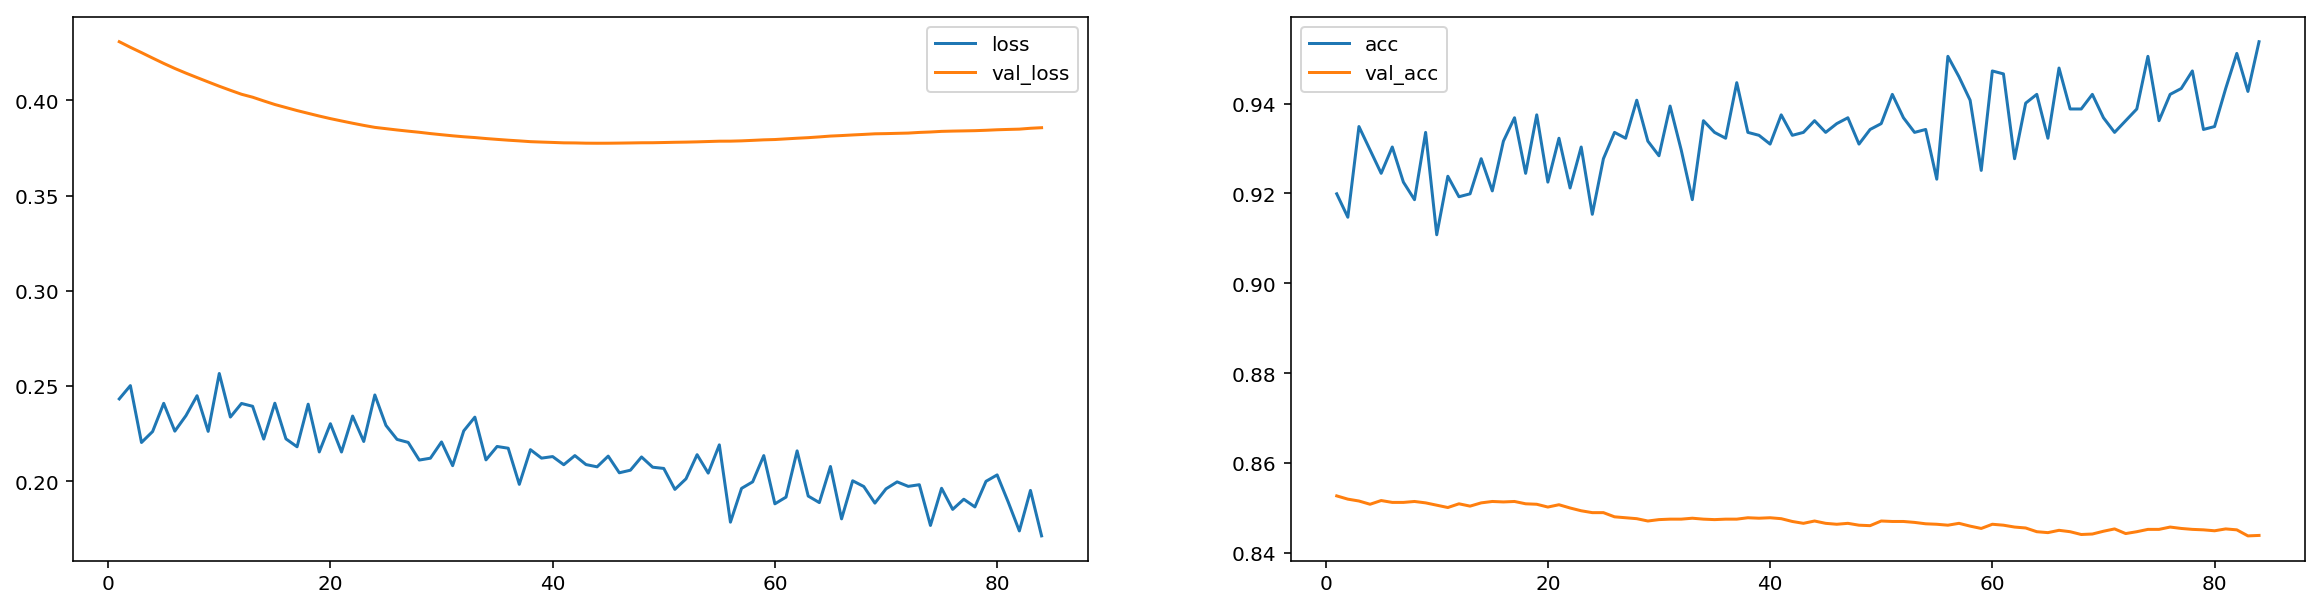

Epoch 00007: val_loss did not improve
14615/14615 [==============================] - 116s 8ms/step - loss: 0.1874 - acc: 0.9430 - val_loss: 0.3860 - val_acc: 0.8443
Epoch 8/10
  256/14615 [..............................] - ETA: 5:47 - loss: 0.1870 - acc: 0.9421

/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (4.771980). Check your callbacks.
  % delta_t_median)


  512/14615 [>.............................] - ETA: 3:25 - loss: 0.1945 - acc: 0.9385

/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (2.386839). Check your callbacks.
  % delta_t_median)


11520/14615 [======================>.......] - ETA: 22s - loss: 0.1821 - acc: 0.9441

KeyboardInterrupt: 

In [20]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='toxic_only.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=5, 
                         x_val=dense_matrix_valid_toxic, 
                         y_val_categorical=Y_valid_toxic)
history = model_sig_nn.fit(dense_matrix_train_toxic, 
          Y_train_toxic, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(dense_matrix_valid_toxic, Y_valid_toxic), 
          callbacks=[plot_losses, checkpointer],
         )